###### Data Preparation



## Data Overview 

Import the numpy and pandas modules.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Data Description

### Transaction Table 
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

## Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

In [2]:
transaction_df = pd.read_csv('./ieee-data/train_transaction.csv')
identity_df = pd.read_csv('./ieee-data/train_identity.csv')
test_transaction = pd.read_csv('./ieee-data/test_transaction.csv')
test_identity = pd.read_csv('./ieee-data/test_identity.csv')

In [3]:
id_cols = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain']
cat_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
train_data_ratio = 0.8

Based on the train/test ratio we assigned before, extact the IDs of test data. 

In [4]:
n_train = int(transaction_df.shape[0]*train_data_ratio)
test_ids = transaction_df.TransactionID.values[n_train:]

In [5]:
get_fraud_frac = lambda series: 100 * sum(series)/len(series)
print("Percent fraud for train transactions: {}".format(get_fraud_frac(transaction_df.isFraud[:n_train])))
print("Percent fraud for test transactions: {}".format(get_fraud_frac(transaction_df.isFraud[n_train:])))
print("Percent fraud for all transactions: {}".format(get_fraud_frac(transaction_df.isFraud)))

Percent fraud for train transactions: 3.5135215226741625
Percent fraud for test transactions: 3.4409184813899145
Percent fraud for all transactions: 3.499000914417313


 Save test IDs into the `test.csv` file

In [6]:
with open('data/test.csv', 'w') as f:
    f.writelines(map(lambda x: str(x) + "\n", test_ids))

Based on the standard we talked about before, define non-feature-columns and feature-columns for creating graph.

In [7]:
non_feature_cols = ['isFraud', 'TransactionDT'] + id_cols
print(non_feature_cols)

['isFraud', 'TransactionDT', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']


In [8]:
feature_cols = [col for col in transaction_df.columns if col not in non_feature_cols]
print(feature_cols)

['TransactionID', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102',

Transfer categorical features to be dummy variables and scale the `TransactionAmt` feature by log10.

In [9]:
features = pd.get_dummies(transaction_df[feature_cols], columns=cat_cols).fillna(0)
features['TransactionAmt'] = features['TransactionAmt'].apply(np.log10)

In [10]:
features.shape

(590540, 391)

In [11]:
print(list(features.columns))

['TransactionID', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109

Save the features into `features.csv` for future training. 

p.s. We don't need the index column and header.

In [12]:
features.to_csv('data/features.csv', index=False, header=False)

Save the IDs and label into the `tags.csv`.

In [13]:
transaction_df[['TransactionID', 'isFraud']].to_csv('data/tags_new.csv', index=False)

Select the columns that define the edges.

In [14]:
edge_types = id_cols + list(identity_df.columns)
print(edge_types)

['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


# HANDLING IMBALANCE DATA:

In [15]:
all_id_cols = ['TransactionID'] +['isFraud']+ id_cols
full_identity_df = transaction_df[all_id_cols].merge(identity_df, on='TransactionID', how='left')
full_identity_df.head(5)

,TransactionID,isFraud,card1,card2,card3,card4,card5,card6,ProductCD,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,13926,NaN,150.0,discover,142.0,credit,W,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,2755,404.0,150.0,mastercard,102.0,credit,W,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,4663,490.0,150.0,visa,166.0,debit,W,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,18132,567.0,150.0,mastercard,117.0,debit,W,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,4497,514.0,150.0,mastercard,102.0,credit,H,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


<Axes: xlabel='isFraud', ylabel='count'>

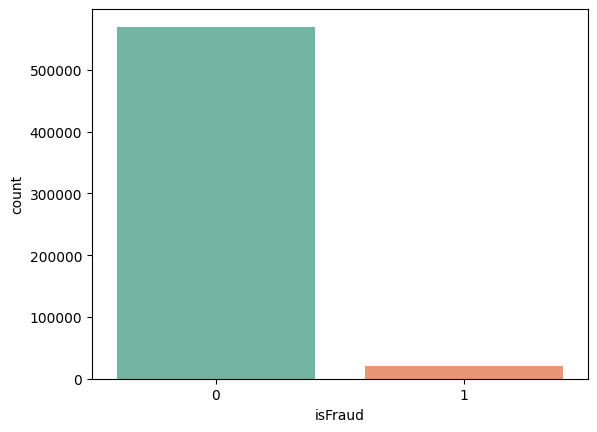

In [16]:
sns.countplot(x=full_identity_df["isFraud"],  palette = "Set2")

From above count_plot we can say that dataset is unbalanced.
Lets perform undersampling for isFraud=0 & SMOTE for for isFraud=1

In [17]:
from imblearn import under_sampling

In [18]:
undsam_df=full_identity_df
X=undsam_df
Y=undsam_df['isFraud']

In [19]:
X.drop('isFraud', axis=1,inplace=True)

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(random_state=0)
x1,y1=rus.fit_resample(X,Y)
print(y1.value_counts(),y1.shape)

0    20663
1    20663
Name: isFraud, dtype: int64 (41326,)


In [21]:
x1.shape

(41326, 52)

In [22]:
full_identity_df=x1

For each identity feature, save the data into the corresponding `relation_{FEATURE NAME}_edgelist.csv`. Each csv file represents one kind of edge.

In [23]:
edges = {}
for etype in edge_types:
    edgelist = full_identity_df[['TransactionID', etype]].dropna()
    edgelist.to_csv('data/relation_{}_edgelist.csv'.format(etype), index=False, header=True)
    edges[etype] = edgelist

print(edges)

{'card1':        TransactionID  card1
0            3491145   3508
1            2990379   8830
2            3219993  12718
3            2987873  12883
4            3019692  12779
...              ...    ...
41321        3577361   3278
41322        3577364   5812
41323        3577368   6758
41324        3577372  14037
41325        3577526   1214

[41326 rows x 2 columns], 'card2':        TransactionID  card2
0            3491145  514.0
1            2990379  250.0
2            3219993  367.0
3            2987873  404.0
4            3019692  100.0
...              ...    ...
41321        3577361  453.0
41322        3577364  408.0
41323        3577368  399.0
41324        3577372  111.0
41325        3577526  174.0

[40602 rows x 2 columns], 'card3':        TransactionID  card3
0            3491145  150.0
1            2990379  150.0
2            3219993  150.0
3            2987873  150.0
4            3019692  150.0
...              ...    ...
41321        3577361  150.0
41322        3577364  

Let's re-check the edges we defined.

In [24]:
import glob

file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

edges_full = ''
for etype in edge_types:
    edges_full += ',data/relation_{}_edgelist.csv'.format(etype)


In [25]:
edges

'relation_TransactionID_edgelist.csv,relation_R_emaildomain_edgelist.csv,relation_P_emaildomain_edgelist.csv,relation_ProductCD_edgelist.csv,relation_id_38_edgelist.csv,relation_id_37_edgelist.csv,relation_id_36_edgelist.csv,relation_id_35_edgelist.csv,relation_id_34_edgelist.csv,relation_id_33_edgelist.csv,relation_id_32_edgelist.csv,relation_id_31_edgelist.csv,relation_id_30_edgelist.csv,relation_id_29_edgelist.csv,relation_id_28_edgelist.csv,relation_id_27_edgelist.csv,relation_id_26_edgelist.csv,relation_id_25_edgelist.csv,relation_id_24_edgelist.csv,relation_id_23_edgelist.csv,relation_id_22_edgelist.csv,relation_id_21_edgelist.csv,relation_id_20_edgelist.csv,relation_id_19_edgelist.csv,relation_id_18_edgelist.csv,relation_id_17_edgelist.csv,relation_id_16_edgelist.csv,relation_id_15_edgelist.csv,relation_id_14_edgelist.csv,relation_id_13_edgelist.csv,relation_id_12_edgelist.csv,relation_id_11_edgelist.csv,relation_id_10_edgelist.csv,relation_id_09_edgelist.csv,relation_id_08_edge